# 决策树实验报告

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import sklearn.tree as sktree
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import warnings
warnings.filterwarnings('ignore')

from preprocess import preprocess
from tree import DecisionTree

以下对Scikit-learn的CART算法，自己按书写的CART算法和C4.5方法，以及数个剪枝方法进行了实验。

自己使用的方法的详细说明见 [this post](https://usualwitch.now.sh/posts/decision-tree/)。

## 实验部分

### 比较CART和C4.5算法

数据集：[Mushroom Data Set](https://archive.ics.uci.edu/ml/datasets/Mushroom)

In [2]:
df = pd.read_csv('data/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


分割训练集和测试集。

#### Scikit-learn CART

+ 按照Scikit-learn中的方法，将X和y分开
+ 将x和y中的categorical variable利用pandas的get_dummies函数转化为dummy-code

In [3]:
y = df['class']
X = df.drop(['class'], axis=1)
X = pd.get_dummies(X)
y = pd.get_dummies(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [5]:
parameters = {
    'criterion': ('gini', 'entropy'),
    'min_samples_split': [2, 3, 4, 5],
    'max_depth': [9, 10, 11, 12],
    'class_weight': ('balanced', None),
    'presort': (False, True)
}

In [6]:
tr = sktree.DecisionTreeClassifier()
gsearch = GridSearchCV(tr, parameters)
gsearch.fit(X_train, y_train)
model = gsearch.best_estimator_
model

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ('balanced', None),
              

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

CART通过grid search建立的决策树在测试集上准确率是100%。

In [7]:
score = model.score(X_test, y_test)
score

1.0

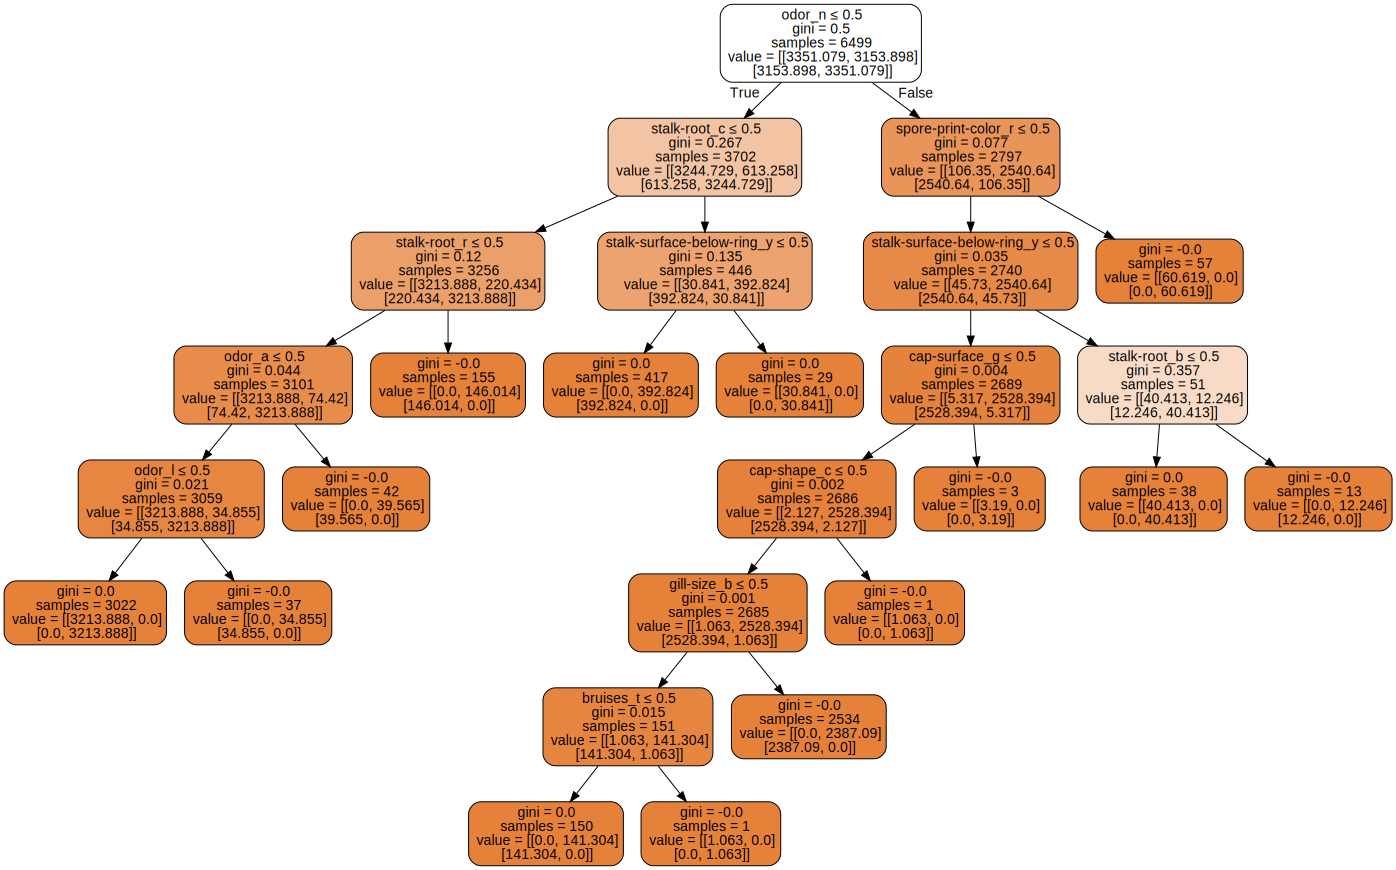

In [8]:
dot_data = sktree.export_graphviz(model, out_file=None,
                                feature_names=X_test.columns,
                               class_names=y_test.columns,
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

sklearn中的CART一般是不剪枝的。提供了ccp_alpha可以设定 $\alpha$ 的值，但是应用起来并不按照CART原来的方法，而是如上在许多超参数中做grid search找出最佳的超参数。

下面都是自己写的算法。

没有将categorical variable转化为dummy-code，直接用了pandas中的categorical type。可能由于类似的工程原因导致效果一般。

#### CART

根据ESL等教材，CART原本的方法是先用weakest link pruning找出一系列 $\alpha$，再用10-fold CV来选择最佳的 $\alpha$ 进行剪枝。在我自己写的决策树类中实现了这一算法。10-fold CV选 $\alpha$ 的过程耗时太长（要建立10*$\alpha$的个数数目的树），因此在代码中改成了 3-fold。

In [9]:
df = pd.read_csv('data/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


将target列调整到最后一列。

In [10]:
col = list(df.columns)[1:] + ['class']
df = df[col]

In [11]:
df.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat', 'class'],
      dtype='object')

pandas处理要求将-换成_。

In [12]:
df.columns = [x.strip().replace('-', '_') for x in df.columns]

In [13]:
df = preprocess(df)
train, test = train_test_split(df, test_size=0.2)

计算过慢，暂不运行。

In [ ]:
dt = DecisionTree(train, algorithm='CART', max_depth=100)
dt.predict(test)

未剪枝的树：

In [ ]:
with open('unpruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

剪枝后的树：

In [ ]:
with open('pruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

#### C4.5

默认进行剪枝。

按照教材和Quinlan的原著写的程序。

In [15]:
train, test = train_test_split(df, test_size=0.33)
dt = DecisionTree(train, algorithm='C4.5', prune_func='Pessim', max_depth=100)
dt.predict(test)

The test accuracy is 51.62%


(0.5162252890712421,
 2930    e
 2492    e
 99      e
 3877    e
 1732    e
        ..
 3635    e
 2533    e
 3443    e
 2144    e
 6802    e
 Name: prediction, Length: 2681, dtype: object)

未剪枝的树：

In [16]:
with open('unpruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

odor

├── f->p

├── n->gill_size

│   ├── b->ring_number

│   │   ├── o->e

│   │   ╰── t->spore_print_color

│   │       ├── w->e

│   │       ╰── r->p

│   ╰── n->stalk_surface_above_ring

│       ├── s->bruises

│       │   ├── f->e

│       │   ╰── t->p

│       ├── k->p

│       ├── f->e

│       ╰── y->p

├── a->e

├── c->p

├── p->p

├── y->p

├── l->e

├── s->p

╰── m->p





剪枝后的树：

In [17]:
with open('pruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

e



可以看到，按照pessimistic pruning，决策树会被直接剪成单结点。说明C4.5的剪枝算法太过悲观，应该少剪一些枝。

### 比较剪枝算法

C4.5剪枝算法采用的是pessimistic pruning，效果如上。下面尝试3种剪枝方法。

1. Reduced Error Pruning，即根据验证集的准确率进行剪枝。
2. 将cost-complexity pruning用在C4.5算法中，进行剪枝，$\alpha = 0.1$。
3. 将cost-complexity pruning的 $|T|$ 改成 $|T|^2$，进行剪枝，$\alpha = 0.01$。

#### Reduced Error Prune

In [18]:
dt = DecisionTree(train, algorithm='C4.5', prune_func='Reduce', max_depth=100)
dt.predict(test)

The test accuracy is 73.14%


(0.7314434912346139,
 2930    p
 2492    p
 99      e
 3877    p
 1732    e
        ..
 3635    p
 2533    p
 3443    p
 2144    p
 6802    p
 Name: prediction, Length: 2681, dtype: object)

未剪枝的树：

In [19]:
with open('unpruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

odor

├── n->gill_size

│   ├── b->ring_number

│   │   ├── t->spore_print_color

│   │   │   ├── w->e

│   │   │   ╰── r->p

│   │   ╰── o->e

│   ╰── n->stalk_surface_above_ring

│       ├── s->bruises

│       │   ├── f->e

│       │   ╰── t->p

│       ├── k->p

│       ├── f->e

│       ╰── y->p

├── y->p

├── c->p

├── f->p

├── l->e

├── s->p

├── a->e

├── p->p

╰── m->p





剪枝后的树：

In [20]:
with open('pruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

odor

├── n->gill_size

│   ├── b->ring_number

│   │   ├── t->spore_print_color

│   │   │   ├── w->e

│   │   │   ╰── r->p

│   │   ╰── o->e

│   ╰── n->stalk_surface_above_ring

│       ├── s->bruises

│       │   ├── f->e

│       │   ╰── t->p

│       ├── k->p

│       ├── f->e

│       ╰── y->p

├── y->p

├── c->p

├── f->p

├── l->e

├── s->p

├── a->e

├── p->p

╰── m->p





#### Cost-complexity Prune

In [21]:
dt = DecisionTree(train, algorithm='C4.5', prune_func='Comp', max_depth=100)
dt.predict(test)

The test accuracy is 73.14%


(0.7314434912346139,
 2930    p
 2492    p
 99      e
 3877    p
 1732    e
        ..
 3635    p
 2533    p
 3443    p
 2144    p
 6802    p
 Name: prediction, Length: 2681, dtype: object)

未剪枝的树：

In [22]:
with open('unpruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

odor

├── n->gill_size

│   ├── b->ring_number

│   │   ├── t->spore_print_color

│   │   │   ├── w->e

│   │   │   ╰── r->p

│   │   ╰── o->e

│   ╰── n->stalk_surface_above_ring

│       ├── s->bruises

│       │   ├── t->p

│       │   ╰── f->e

│       ├── k->p

│       ├── f->e

│       ╰── y->p

├── p->p

├── l->e

├── c->p

├── f->p

├── y->p

├── a->e

├── s->p

╰── m->p





剪枝后的树：

In [23]:
with open('pruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

odor

├── n->gill_size

│   ├── b->ring_number

│   │   ├── t->spore_print_color

│   │   │   ├── w->e

│   │   │   ╰── r->p

│   │   ╰── o->e

│   ╰── n->stalk_surface_above_ring

│       ├── s->bruises

│       │   ├── t->p

│       │   ╰── f->e

│       ├── k->p

│       ├── f->e

│       ╰── y->p

├── p->p

├── l->e

├── c->p

├── f->p

├── y->p

├── a->e

├── s->p

╰── m->p





#### Cost-complexity Squared Prune

In [24]:
dt = DecisionTree(train, algorithm='C4.5', prune_func='CompSqr', max_depth=100)
dt.predict(test)

The test accuracy is 74.90%


(0.7489742633345766,
 2930    p
 2492    p
 99      e
 3877    p
 1732    e
        ..
 3635    p
 2533    p
 3443    p
 2144    p
 6802    p
 Name: prediction, Length: 2681, dtype: object)

未剪枝的树：

In [25]:
with open('unpruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

odor

├── n->gill_size

│   ├── b->ring_number

│   │   ├── o->e

│   │   ╰── t->spore_print_color

│   │       ├── w->e

│   │       ╰── r->p

│   ╰── n->stalk_surface_above_ring

│       ├── k->p

│       ├── s->bruises

│       │   ├── f->e

│       │   ╰── t->p

│       ├── f->e

│       ╰── y->p

├── y->p

├── a->e

├── f->p

├── l->e

├── c->p

├── s->p

├── p->p

╰── m->p





剪枝后的树：

In [26]:
with open('pruned_tree.txt') as f:
    lines = f.readlines()
    for line in lines:
        print(line)

odor

├── n->gill_size

│   ├── b->ring_number

│   │   ├── o->e

│   │   ╰── t->e

│   ╰── n->stalk_surface_above_ring

│       ├── k->p

│       ├── s->bruises

│       │   ├── f->e

│       │   ╰── t->p

│       ├── f->e

│       ╰── y->p

├── y->p

├── a->e

├── f->p

├── l->e

├── c->p

├── s->p

├── p->p

╰── m->p





## 总结部分

### 算法比较

比较上述实验结果可知，Scikit-learn CART对超参数空间进行grid search能够得到最好的预测结果。说明生成正确的树，比剪枝更为重要。

自己写的CART运行速度过慢，不具备实用性，且预测准确率也一般。若不调节超参数，经常为50%左右，所以比起对剪枝参数 $\alpha$ 的选择，还是超参数选择更加重要。运行速度慢还有对Categorical Type的处理问题，因为没有工程经验，没有转化成dummy-code进行处理，盲目依照书本是不行的。

按照Quinlan的书写的C4.5 with pessimistic pruning过于悲观，我尝试过几个数据集最后都只剩一个结点了，说明这种方法不太有用，现在也没什么人使用。

### 剪枝方法比较

排除掉C4.5本身十分悲观的pruning方法后，多次尝试的3种剪枝方法：

1. Reduced Error Pruning，即根据验证集的准确率进行剪枝。
2. 将cost-complexity pruning用在C4.5算法中，进行剪枝，$\alpha = 0.1$。
3. 将cost-complexity pruning的 $|T|$ 改成 $|T|^2$，进行剪枝，$\alpha = 0.01$。

得到的结果为3优于2优于1。差异不显著，且每个剪枝算法内部都有一些可调的参数：1中可以调节验证集的比例，这里取20%较好；2、3中可以调节 $\alpha$ 的值。总体看来，算法的选择还是高度依赖于问题本身的，这也就是为什么生成树使用的超参数对预测效果极为关键吧。